In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,BatchNormalization, Normalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import log_loss

In [13]:
df = pd.read_csv('train.csv', index_col='id')
df

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,1166,D-penicillamine,16839,F,N,N,N,N,0.8,309.0,3.56,38.0,1629.0,79.05,224.0,344.0,9.9,2.0,C
7901,1492,Placebo,17031,F,N,Y,N,N,0.9,260.0,3.43,62.0,1440.0,142.00,78.0,277.0,10.0,4.0,C
7902,1576,D-penicillamine,25873,F,N,N,Y,S,2.0,225.0,3.19,51.0,933.0,69.75,62.0,200.0,12.7,2.0,D


### Eliminamos los datos atipicos del dataset

In [19]:
def outliers(df, lower_limit=0.01, upper_limit=0.99):
    copy_df = df.copy()    
    column_names = copy_df[['Bilirubin','Cholesterol','Copper','Alk_Phos','SGOT','Tryglicerides','Prothrombin']]
    
    # Iteramos por columna, eliminando las filas cuyo rango sea detectado como atipico
    for i in column_names:
        # Calcula percentiles para limitar los valores atípicos
        lower_percentile = copy_df[i].quantile(lower_limit)
        upper_percentile = copy_df[i].quantile(upper_limit)

        # Identifica y elimina las filas que contienen valores atípicos
        copy_df = copy_df[~((copy_df[i] < lower_percentile) | (copy_df[i] > upper_percentile))]

    return copy_df

In [20]:
df = outliers(df)

In [113]:
# Separamos en variables dependientes y independientes
X = df.drop('Status', axis=1)
y = df['Status']

### Transformacion distribucion de variables 

In [53]:
class Tranformation_Distribution (BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):       
        return self
    
    # Iteramos por el nombre de columna de X_copy, devolviendo el valor devuelto por boxcox (no el valor lambda).
    def transform(self,X):
        X_copy = X.copy()    
        column_names = ['Bilirubin','Cholesterol','Copper','Alk_Phos','SGOT','Tryglicerides','Prothrombin']
        
        for i in column_names:
            transformed_col,_ = stats.boxcox(X_copy[i])
            X_copy[i] = transformed_col
        
        return X_copy

In [114]:
transformers_ = Tranformation_Distribution()
X = transformers_.transform(X)

In [115]:
X.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
id,,,,,,,,,,,,,,,,,,
0,999,D-penicillamine,21532,M,N,N,N,N,0.672437,0.935953,3.35,5.163790,1.627679,6.881744,2.664122,394.0,0.274278,3.0
1,2574,Placebo,19237,F,N,N,N,N,-0.108379,0.936237,3.54,4.153688,1.626441,6.395685,2.787351,361.0,0.274303,3.0
2,3428,Placebo,13727,F,N,Y,Y,Y,0.882976,0.935830,3.55,4.889813,1.621943,6.193735,2.573153,199.0,0.274312,4.0
3,2576,Placebo,18460,F,N,N,N,N,-0.587231,0.935442,3.50,4.070578,1.628037,5.369338,2.817901,269.0,0.274299,3.0
4,788,Placebo,16658,F,N,Y,N,N,0.092927,0.936140,3.65,4.153688,1.623898,6.277186,2.817901,298.0,0.274297,4.0


### Escalamos y codificamos

In [116]:
# Codificar variable categoricas
categorical = X.select_dtypes(exclude='number')

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
encoded_data = encoder.fit_transform(categorical)
columns_names_ = encoder.get_feature_names_out(categorical.columns)

# Transformar a df para concadenar a numericas
categorical_df = pd.DataFrame(encoded_data, columns=columns_names_)
categorical_df.reset_index(drop=True, inplace=True)


In [117]:
# normaalizar variables numericas
numerical = X.select_dtypes(include='number')
columns_names_n = numerical.columns

scaler = MinMaxScaler()
numerical_scaled = scaler.fit_transform(numerical)
# Transformar a df para concadenar con categoricas
numerical_df = pd.DataFrame(numerical_scaled, columns=columns_names_n)

In [118]:
# Concadenamos a nuevo df
X_original = pd.concat([numerical_df, categorical_df], axis = 1)
X_original

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug_Placebo,Sex_M,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Edema_S,Edema_Y
0,0.201515,0.626391,0.692680,0.607335,0.518657,0.764671,0.670769,0.817726,0.151434,0.662675,0.107348,0.666667,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.532814,0.505931,0.400987,0.678317,0.589552,0.494409,0.639070,0.638081,0.356572,0.596806,0.607669,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.712453,0.216723,0.771332,0.576535,0.593284,0.691366,0.523939,0.563442,0.000000,0.273453,0.780912,1.000000,1.0,0.0,0.0,1.0,1.0,0.0,1.0
3,0.533235,0.465148,0.222100,0.479683,0.574627,0.472172,0.679935,0.258750,0.407427,0.413174,0.516443,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.157131,0.370565,0.476190,0.654082,0.630597,0.494409,0.573997,0.594285,0.407427,0.471058,0.483314,1.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6997,0.236643,0.380065,0.352948,0.595077,0.597015,0.358497,0.675763,0.318479,0.852582,0.562874,0.204890,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6998,0.305217,0.390143,0.400987,0.490091,0.548507,0.490106,0.639070,0.669949,0.284353,0.429142,0.250322,1.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0
6999,0.322886,0.854241,0.657924,0.386024,0.458955,0.437590,0.485719,0.246109,0.141209,0.275449,0.958435,0.333333,0.0,0.0,0.0,0.0,1.0,1.0,0.0
7000,0.745267,0.701344,0.294705,0.457827,0.294776,0.312316,0.514170,0.134800,0.524006,0.317365,0.483314,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [130]:
# codificamos y
scaler_y = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_y = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [133]:
encoded_y

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

### Prediccion con redes neuronales

In [135]:
X_train,X_test, y_train, y_test = train_test_split(X_original, encoded_y, test_size=0.2, random_state=42, stratify=encoded_y)

In [204]:
# Arquitectura de red
tf.random.set_seed(42)

modelo = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='relu', input_dim=19),
    BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(25, activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Dense(25, activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(3, activation='softmax'),
])

optimizador = tf.keras.optimizers.Adam(learning_rate=0.0005)
modelo.compile(optimizer=optimizador, loss='categorical_crossentropy', metrics=['accuracy'])

modelo.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 25)                500       
                                                                 
 batch_normalization_40 (Ba  (None, 25)                100       
 tchNormalization)                                               
                                                                 
 dropout_24 (Dropout)        (None, 25)                0         
                                                                 
 dense_62 (Dense)            (None, 25)                650       
                                                                 
 batch_normalization_41 (Ba  (None, 25)                100       
 tchNormalization)                                               
                                                                 
 dense_63 (Dense)            (None, 25)              

In [205]:
# Ajustar y entrenar el modelo de red neuronal
early_stop = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
filepath='./checkpoints/checkpoint'
best_model = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,save_best_only=True, save_weigth_only=False, 
                                                monitor='val_loss', mode='min')
history=modelo.fit(X_train, y_train ,batch_size= 35, callbacks=[early_stop, best_model] ,epochs=400,validation_data=(X_test, y_test))

Epoch 1/400
154/161 [===========================>..] - ETA: 0s - loss: 1.3904 - accuracy: 0.4234INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 4s 14ms/step - loss: 1.3763 - accuracy: 0.4267 - val_loss: 1.0228 - val_accuracy: 0.5553
Epoch 2/400
158/161 [============================>.] - ETA: 0s - loss: 0.9672 - accuracy: 0.5864INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.9661 - accuracy: 0.5869 - val_loss: 0.7330 - val_accuracy: 0.7780
Epoch 3/400
143/161 [=========================>....] - ETA: 0s - loss: 0.8211 - accuracy: 0.6681INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.8184 - accuracy: 0.6711 - val_loss: 0.6275 - val_accuracy: 0.7852
Epoch 4/400
158/161 [============================>.] - ETA: 0s - loss: 0.7395 - accuracy: 0.7112INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.7384 - accuracy: 0.7117 - val_loss: 0.5928 - val_accuracy: 0.7894
Epoch 5/400
157/161 [============================>.] - ETA: 0s - loss: 0.6857 - accuracy: 0.7416INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 3s 16ms/step - loss: 0.6837 - accuracy: 0.7422 - val_loss: 0.5651 - val_accuracy: 0.7887
Epoch 6/400
143/161 [=========================>....] - ETA: 0s - loss: 0.6681 - accuracy: 0.7570INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.6652 - accuracy: 0.7574 - val_loss: 0.5554 - val_accuracy: 0.7909
Epoch 7/400
148/161 [==========================>...] - ETA: 0s - loss: 0.6381 - accuracy: 0.7670INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 13ms/step - loss: 0.6393 - accuracy: 0.7654 - val_loss: 0.5511 - val_accuracy: 0.7944
Epoch 8/400
159/161 [============================>.] - ETA: 0s - loss: 0.6314 - accuracy: 0.7603INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.6331 - accuracy: 0.7595 - val_loss: 0.5488 - val_accuracy: 0.7951
Epoch 9/400
150/161 [==========================>...] - ETA: 0s - loss: 0.6164 - accuracy: 0.7676INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 13ms/step - loss: 0.6178 - accuracy: 0.7666 - val_loss: 0.5445 - val_accuracy: 0.7973
Epoch 10/400
154/161 [===========================>..] - ETA: 0s - loss: 0.6034 - accuracy: 0.7768INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.6035 - accuracy: 0.7756 - val_loss: 0.5411 - val_accuracy: 0.7980
Epoch 11/400
150/161 [==========================>...] - ETA: 0s - loss: 0.5977 - accuracy: 0.7756INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 13ms/step - loss: 0.5964 - accuracy: 0.7758 - val_loss: 0.5399 - val_accuracy: 0.7966
Epoch 12/400
157/161 [============================>.] - ETA: 0s - loss: 0.5843 - accuracy: 0.7780INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5838 - accuracy: 0.7783 - val_loss: 0.5348 - val_accuracy: 0.7973
Epoch 13/400
154/161 [===========================>..] - ETA: 0s - loss: 0.5946 - accuracy: 0.7718INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5920 - accuracy: 0.7736 - val_loss: 0.5342 - val_accuracy: 0.7951
Epoch 14/400
157/161 [============================>.] - ETA: 0s - loss: 0.5792 - accuracy: 0.7793INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 3s 17ms/step - loss: 0.5777 - accuracy: 0.7802 - val_loss: 0.5315 - val_accuracy: 0.7951
Epoch 15/400
158/161 [============================>.] - ETA: 0s - loss: 0.5812 - accuracy: 0.7796INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5805 - accuracy: 0.7795 - val_loss: 0.5308 - val_accuracy: 0.7951
Epoch 16/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5837 - accuracy: 0.7777 - val_loss: 0.5310 - val_accuracy: 0.7973
Epoch 17/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5746 - accuracy: 0.7825 - val_loss: 0.5314 - val_accuracy: 0.7951
Epoch 18/400
148/161 [==========================>...] - ETA: 0s - loss: 0.5760 - accuracy: 0.7844INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5780 - accuracy: 0.7825 - val_loss: 0.5307 - val_accuracy: 0.7937
Epoch 19/400
144/161 [=========================>....] - ETA: 0s - loss: 0.5664 - accuracy: 0.7825INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5716 - accuracy: 0.7827 - val_loss: 0.5299 - val_accuracy: 0.7930
Epoch 20/400
158/161 [============================>.] - ETA: 0s - loss: 0.5621 - accuracy: 0.7882INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 13ms/step - loss: 0.5652 - accuracy: 0.7859 - val_loss: 0.5283 - val_accuracy: 0.7951
Epoch 21/400
161/161 [==============================] - 1s 3ms/step - loss: 0.5577 - accuracy: 0.7879 - val_loss: 0.5285 - val_accuracy: 0.7944
Epoch 22/400
145/161 [==========================>...] - ETA: 0s - loss: 0.5592 - accuracy: 0.7882INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5609 - accuracy: 0.7890 - val_loss: 0.5273 - val_accuracy: 0.7916
Epoch 23/400
158/161 [============================>.] - ETA: 0s - loss: 0.5670 - accuracy: 0.7895INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5648 - accuracy: 0.7908 - val_loss: 0.5269 - val_accuracy: 0.7944
Epoch 24/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5616 - accuracy: 0.7920 - val_loss: 0.5270 - val_accuracy: 0.7966
Epoch 25/400
150/161 [==========================>...] - ETA: 0s - loss: 0.5480 - accuracy: 0.7918INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5512 - accuracy: 0.7899 - val_loss: 0.5265 - val_accuracy: 0.7973
Epoch 26/400
157/161 [============================>.] - ETA: 0s - loss: 0.5464 - accuracy: 0.7931INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5463 - accuracy: 0.7933 - val_loss: 0.5254 - val_accuracy: 0.7951
Epoch 27/400
143/161 [=========================>....] - ETA: 0s - loss: 0.5593 - accuracy: 0.7930INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 3s 16ms/step - loss: 0.5606 - accuracy: 0.7902 - val_loss: 0.5247 - val_accuracy: 0.7973
Epoch 28/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5532 - accuracy: 0.7929 - val_loss: 0.5256 - val_accuracy: 0.7937
Epoch 29/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5499 - accuracy: 0.7890 - val_loss: 0.5248 - val_accuracy: 0.7973
Epoch 30/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5529 - accuracy: 0.7920 - val_loss: 0.5257 - val_accuracy: 0.7973
Epoch 31/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5549 - accuracy: 0.7933 - val_loss: 0.5260 - val_accuracy: 0.7951
Epoch 32/400
161/161 [==============================] - 1s 3ms/step - loss: 0.5509 - accuracy: 0.7861 - val_loss: 0.5255 - val_accuracy: 0.7973
Epoch 33/400
161/161 [==============================] - 1s 3ms/step - loss: 0.5507 - accuracy: 0.7920 - val_loss: 0.5247 - val_accuracy: 0.7959
Epoc

INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5524 - accuracy: 0.7936 - val_loss: 0.5247 - val_accuracy: 0.7909
Epoch 37/400
155/161 [===========================>..] - ETA: 0s - loss: 0.5451 - accuracy: 0.7904INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5458 - accuracy: 0.7906 - val_loss: 0.5230 - val_accuracy: 0.7959
Epoch 38/400
160/161 [============================>.] - ETA: 0s - loss: 0.5410 - accuracy: 0.7912INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 13ms/step - loss: 0.5411 - accuracy: 0.7911 - val_loss: 0.5227 - val_accuracy: 0.7937
Epoch 39/400
142/161 [=========================>....] - ETA: 0s - loss: 0.5450 - accuracy: 0.7913INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5471 - accuracy: 0.7908 - val_loss: 0.5223 - val_accuracy: 0.7944
Epoch 40/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5475 - accuracy: 0.7925 - val_loss: 0.5228 - val_accuracy: 0.7916
Epoch 41/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5462 - accuracy: 0.7941 - val_loss: 0.5233 - val_accuracy: 0.7959
Epoch 42/400
161/161 [==============================] - 1s 3ms/step - loss: 0.5416 - accuracy: 0.7959 - val_loss: 0.5226 - val_accuracy: 0.7959
Epoch 43/400
142/161 [=========================>....] - ETA: 0s - loss: 0.5420 - accuracy: 0.7948INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 13ms/step - loss: 0.5461 - accuracy: 0.7916 - val_loss: 0.5215 - val_accuracy: 0.7959
Epoch 44/400
141/161 [=========================>....] - ETA: 0s - loss: 0.5470 - accuracy: 0.7941INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5455 - accuracy: 0.7934 - val_loss: 0.5213 - val_accuracy: 0.7966
Epoch 45/400
147/161 [==========================>...] - ETA: 0s - loss: 0.5326 - accuracy: 0.8010INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5360 - accuracy: 0.7997 - val_loss: 0.5198 - val_accuracy: 0.7973
Epoch 46/400
147/161 [==========================>...] - ETA: 0s - loss: 0.5487 - accuracy: 0.7965INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5457 - accuracy: 0.7981 - val_loss: 0.5197 - val_accuracy: 0.7959
Epoch 47/400
161/161 [==============================] - ETA: 0s - loss: 0.5386 - accuracy: 0.7961INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5386 - accuracy: 0.7961 - val_loss: 0.5197 - val_accuracy: 0.7951
Epoch 48/400
158/161 [============================>.] - ETA: 0s - loss: 0.5384 - accuracy: 0.7922INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 3s 16ms/step - loss: 0.5394 - accuracy: 0.7924 - val_loss: 0.5194 - val_accuracy: 0.7966
Epoch 49/400
145/161 [==========================>...] - ETA: 0s - loss: 0.5440 - accuracy: 0.7931INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5461 - accuracy: 0.7925 - val_loss: 0.5192 - val_accuracy: 0.7980
Epoch 50/400
157/161 [============================>.] - ETA: 0s - loss: 0.5430 - accuracy: 0.7978INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5440 - accuracy: 0.7974 - val_loss: 0.5189 - val_accuracy: 0.7930
Epoch 51/400
161/161 [==============================] - ETA: 0s - loss: 0.5411 - accuracy: 0.7922INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5411 - accuracy: 0.7922 - val_loss: 0.5181 - val_accuracy: 0.7980
Epoch 52/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5369 - accuracy: 0.7940 - val_loss: 0.5183 - val_accuracy: 0.7937
Epoch 53/400
161/161 [==============================] - ETA: 0s - loss: 0.5353 - accuracy: 0.7990INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5353 - accuracy: 0.7990 - val_loss: 0.5174 - val_accuracy: 0.7937
Epoch 54/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5376 - accuracy: 0.7975 - val_loss: 0.5182 - val_accuracy: 0.7966
Epoch 55/400
161/161 [==============================] - 1s 3ms/step - loss: 0.5387 - accuracy: 0.8011 - val_loss: 0.5175 - val_accuracy: 0.7959
Epoch 56/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5341 - accuracy: 0.8006 - val_loss: 0.5175 - val_accuracy: 0.7951
Epoch 57/400
158/161 [============================>.] - ETA: 0s - loss: 0.5371 - accuracy: 0.7975INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5374 - accuracy: 0.7974 - val_loss: 0.5167 - val_accuracy: 0.7944
Epoch 58/400
151/161 [===========================>..] - ETA: 0s - loss: 0.5341 - accuracy: 0.8000INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 13ms/step - loss: 0.5337 - accuracy: 0.7997 - val_loss: 0.5156 - val_accuracy: 0.7951
Epoch 59/400
161/161 [==============================] - 1s 3ms/step - loss: 0.5360 - accuracy: 0.7983 - val_loss: 0.5165 - val_accuracy: 0.7944
Epoch 60/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5379 - accuracy: 0.7922 - val_loss: 0.5169 - val_accuracy: 0.7937
Epoch 61/400
161/161 [==============================] - 1s 3ms/step - loss: 0.5333 - accuracy: 0.8016 - val_loss: 0.5165 - val_accuracy: 0.7966
Epoch 62/400
161/161 [==============================] - 1s 3ms/step - loss: 0.5386 - accuracy: 0.7949 - val_loss: 0.5165 - val_accuracy: 0.7959
Epoch 63/400
159/161 [============================>.] - ETA: 0s - loss: 0.5341 - accuracy: 0.8004INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 13ms/step - loss: 0.5347 - accuracy: 0.7995 - val_loss: 0.5150 - val_accuracy: 0.7951
Epoch 64/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5393 - accuracy: 0.7949 - val_loss: 0.5151 - val_accuracy: 0.7937
Epoch 65/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5407 - accuracy: 0.7975 - val_loss: 0.5158 - val_accuracy: 0.7951
Epoch 66/400
146/161 [==========================>...] - ETA: 0s - loss: 0.5424 - accuracy: 0.7945INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5383 - accuracy: 0.7968 - val_loss: 0.5149 - val_accuracy: 0.7951
Epoch 67/400
143/161 [=========================>....] - ETA: 0s - loss: 0.5291 - accuracy: 0.7970INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 3s 16ms/step - loss: 0.5280 - accuracy: 0.7988 - val_loss: 0.5141 - val_accuracy: 0.7951
Epoch 68/400
145/161 [==========================>...] - ETA: 0s - loss: 0.5277 - accuracy: 0.7976INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5272 - accuracy: 0.7995 - val_loss: 0.5140 - val_accuracy: 0.7973
Epoch 69/400
150/161 [==========================>...] - ETA: 0s - loss: 0.5276 - accuracy: 0.7973INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5325 - accuracy: 0.7940 - val_loss: 0.5134 - val_accuracy: 0.7980
Epoch 70/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5313 - accuracy: 0.7999 - val_loss: 0.5147 - val_accuracy: 0.7959
Epoch 71/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5302 - accuracy: 0.7966 - val_loss: 0.5142 - val_accuracy: 0.7994
Epoch 72/400
161/161 [==============================] - ETA: 0s - loss: 0.5288 - accuracy: 0.7977INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5288 - accuracy: 0.7977 - val_loss: 0.5132 - val_accuracy: 0.7980
Epoch 73/400
161/161 [==============================] - 1s 3ms/step - loss: 0.5301 - accuracy: 0.7979 - val_loss: 0.5137 - val_accuracy: 0.7959
Epoch 74/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5288 - accuracy: 0.7959 - val_loss: 0.5137 - val_accuracy: 0.7951
Epoch 75/400
145/161 [==========================>...] - ETA: 0s - loss: 0.5239 - accuracy: 0.7996INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5260 - accuracy: 0.8002 - val_loss: 0.5130 - val_accuracy: 0.7951
Epoch 76/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5275 - accuracy: 0.7979 - val_loss: 0.5131 - val_accuracy: 0.7959
Epoch 77/400
146/161 [==========================>...] - ETA: 0s - loss: 0.5266 - accuracy: 0.8041INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5309 - accuracy: 0.8015 - val_loss: 0.5127 - val_accuracy: 0.7951
Epoch 78/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5265 - accuracy: 0.7990 - val_loss: 0.5144 - val_accuracy: 0.8001
Epoch 79/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5287 - accuracy: 0.7954 - val_loss: 0.5130 - val_accuracy: 0.7980
Epoch 80/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5264 - accuracy: 0.8004 - val_loss: 0.5136 - val_accuracy: 0.7930
Epoch 81/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5231 - accuracy: 0.7975 - val_loss: 0.5137 - val_accuracy: 0.7951
Epoch 82/400
160/161 [============================>.] - ETA: 0s - loss: 0.5327 - accuracy: 0.7993INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5329 - accuracy: 0.7991 - val_loss: 0.5125 - val_accuracy: 0.7966
Epoch 83/400
160/161 [============================>.] - ETA: 0s - loss: 0.5352 - accuracy: 0.8009INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5351 - accuracy: 0.8009 - val_loss: 0.5121 - val_accuracy: 0.7973
Epoch 84/400
161/161 [==============================] - 1s 3ms/step - loss: 0.5315 - accuracy: 0.7983 - val_loss: 0.5128 - val_accuracy: 0.7973
Epoch 85/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5247 - accuracy: 0.8000 - val_loss: 0.5130 - val_accuracy: 0.7916
Epoch 86/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5269 - accuracy: 0.7922 - val_loss: 0.5139 - val_accuracy: 0.7973
Epoch 87/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5241 - accuracy: 0.8009 - val_loss: 0.5133 - val_accuracy: 0.7944
Epoch 88/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5249 - accuracy: 0.8004 - val_loss: 0.5132 - val_accuracy: 0.7944
Epoch 89/400
141/161 [=========================>....] - ETA: 0s - loss: 0.5218 - accuracy: 0.8002INFO:tensorflow:Assets written to: ./checkpoints\ch

INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5267 - accuracy: 0.7995 - val_loss: 0.5121 - val_accuracy: 0.7994
Epoch 90/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5329 - accuracy: 0.7945 - val_loss: 0.5133 - val_accuracy: 0.8009
Epoch 91/400
158/161 [============================>.] - ETA: 0s - loss: 0.5316 - accuracy: 0.7949INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 3s 16ms/step - loss: 0.5323 - accuracy: 0.7954 - val_loss: 0.5113 - val_accuracy: 0.8009
Epoch 92/400
143/161 [=========================>....] - ETA: 0s - loss: 0.5303 - accuracy: 0.7968INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5274 - accuracy: 0.7975 - val_loss: 0.5099 - val_accuracy: 0.8001
Epoch 93/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5215 - accuracy: 0.7981 - val_loss: 0.5104 - val_accuracy: 0.7980
Epoch 94/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5290 - accuracy: 0.7915 - val_loss: 0.5104 - val_accuracy: 0.7994
Epoch 95/400
148/161 [==========================>...] - ETA: 0s - loss: 0.5228 - accuracy: 0.7981INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5248 - accuracy: 0.7979 - val_loss: 0.5097 - val_accuracy: 0.8009
Epoch 96/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5306 - accuracy: 0.7974 - val_loss: 0.5108 - val_accuracy: 0.8009
Epoch 97/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5246 - accuracy: 0.8018 - val_loss: 0.5102 - val_accuracy: 0.8016
Epoch 98/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5202 - accuracy: 0.8016 - val_loss: 0.5107 - val_accuracy: 0.7987
Epoch 99/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5218 - accuracy: 0.8024 - val_loss: 0.5101 - val_accuracy: 0.7966
Epoch 100/400
161/161 [==============================] - 1s 3ms/step - loss: 0.5243 - accuracy: 0.7983 - val_loss: 0.5100 - val_accuracy: 0.7966
Epoch 101/400
141/161 [=========================>....] - ETA: 0s - loss: 0.5213 - accuracy: 0.7974INFO:tensorflow:Assets written to: ./checkpoints\

INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5194 - accuracy: 0.7984 - val_loss: 0.5091 - val_accuracy: 0.7994
Epoch 102/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5228 - accuracy: 0.8054 - val_loss: 0.5102 - val_accuracy: 0.7959
Epoch 103/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5249 - accuracy: 0.8015 - val_loss: 0.5094 - val_accuracy: 0.7944
Epoch 104/400
146/161 [==========================>...] - ETA: 0s - loss: 0.5275 - accuracy: 0.7959INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5257 - accuracy: 0.7965 - val_loss: 0.5085 - val_accuracy: 0.7987
Epoch 105/400
161/161 [==============================] - 1s 3ms/step - loss: 0.5241 - accuracy: 0.8000 - val_loss: 0.5097 - val_accuracy: 0.7987
Epoch 106/400
161/161 [==============================] - 1s 3ms/step - loss: 0.5163 - accuracy: 0.8036 - val_loss: 0.5088 - val_accuracy: 0.8009
Epoch 107/400
161/161 [==============================] - 1s 3ms/step - loss: 0.5193 - accuracy: 0.8029 - val_loss: 0.5086 - val_accuracy: 0.8001
Epoch 108/400
161/161 [==============================] - 1s 3ms/step - loss: 0.5260 - accuracy: 0.7988 - val_loss: 0.5089 - val_accuracy: 0.8037
Epoch 109/400
161/161 [==============================] - 1s 4ms/step - loss: 0.5221 - accuracy: 0.7984 - val_loss: 0.5088 - val_accuracy: 0.8030
Epoch 110/400
142/161 [=========================>....] - ETA: 0s - loss: 0.5192 - accuracy: 0.7990INFO:tensorflow:Assets written to: ./checkpoi

INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5250 - accuracy: 0.7963 - val_loss: 0.5073 - val_accuracy: 0.8023
Epoch 111/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5272 - accuracy: 0.7958 - val_loss: 0.5083 - val_accuracy: 0.8001
Epoch 112/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5231 - accuracy: 0.7959 - val_loss: 0.5074 - val_accuracy: 0.7980
Epoch 113/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5277 - accuracy: 0.8009 - val_loss: 0.5080 - val_accuracy: 0.7987
Epoch 114/400
145/161 [==========================>...] - ETA: 0s - loss: 0.5258 - accuracy: 0.8000INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5232 - accuracy: 0.8015 - val_loss: 0.5070 - val_accuracy: 0.7987
Epoch 115/400
145/161 [==========================>...] - ETA: 0s - loss: 0.5227 - accuracy: 0.8022INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5222 - accuracy: 0.8020 - val_loss: 0.5068 - val_accuracy: 0.7980
Epoch 116/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5228 - accuracy: 0.8018 - val_loss: 0.5099 - val_accuracy: 0.7966
Epoch 117/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5177 - accuracy: 0.8029 - val_loss: 0.5082 - val_accuracy: 0.7987
Epoch 118/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5204 - accuracy: 0.7977 - val_loss: 0.5072 - val_accuracy: 0.8016
Epoch 119/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5212 - accuracy: 0.7997 - val_loss: 0.5070 - val_accuracy: 0.8016
Epoch 120/400
146/161 [==========================>...] - ETA: 0s - loss: 0.5185 - accuracy: 0.8008INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5217 - accuracy: 0.7999 - val_loss: 0.5063 - val_accuracy: 0.8030
Epoch 121/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5145 - accuracy: 0.8024 - val_loss: 0.5070 - val_accuracy: 0.8037
Epoch 122/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5243 - accuracy: 0.7947 - val_loss: 0.5091 - val_accuracy: 0.8009
Epoch 123/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5245 - accuracy: 0.7990 - val_loss: 0.5084 - val_accuracy: 0.7966
Epoch 124/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5164 - accuracy: 0.8050 - val_loss: 0.5075 - val_accuracy: 0.8009
Epoch 125/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5146 - accuracy: 0.8077 - val_loss: 0.5068 - val_accuracy: 0.8009
Epoch 126/400
148/161 [==========================>...] - ETA: 0s - loss: 0.5238 - accuracy: 0.7979INFO:tensorflow:Assets written to: ./checkpoi

INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 3s 17ms/step - loss: 0.5218 - accuracy: 0.7981 - val_loss: 0.5062 - val_accuracy: 0.8016
Epoch 127/400
161/161 [==============================] - 1s 3ms/step - loss: 0.5160 - accuracy: 0.8057 - val_loss: 0.5072 - val_accuracy: 0.8016
Epoch 128/400
155/161 [===========================>..] - ETA: 0s - loss: 0.5122 - accuracy: 0.8028INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5097 - accuracy: 0.8041 - val_loss: 0.5056 - val_accuracy: 0.8001
Epoch 129/400
161/161 [==============================] - 1s 3ms/step - loss: 0.5129 - accuracy: 0.8049 - val_loss: 0.5075 - val_accuracy: 0.8037
Epoch 130/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5140 - accuracy: 0.8027 - val_loss: 0.5063 - val_accuracy: 0.7994
Epoch 131/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5218 - accuracy: 0.7941 - val_loss: 0.5064 - val_accuracy: 0.8023
Epoch 132/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5125 - accuracy: 0.8004 - val_loss: 0.5060 - val_accuracy: 0.8037
Epoch 133/400
145/161 [==========================>...] - ETA: 0s - loss: 0.5090 - accuracy: 0.8057INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5156 - accuracy: 0.8038 - val_loss: 0.5046 - val_accuracy: 0.8009
Epoch 134/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5168 - accuracy: 0.8018 - val_loss: 0.5053 - val_accuracy: 0.8001
Epoch 135/400
144/161 [=========================>....] - ETA: 0s - loss: 0.5123 - accuracy: 0.8022INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5125 - accuracy: 0.8025 - val_loss: 0.5046 - val_accuracy: 0.8023
Epoch 136/400
142/161 [=========================>....] - ETA: 0s - loss: 0.5120 - accuracy: 0.8018INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5141 - accuracy: 0.8029 - val_loss: 0.5036 - val_accuracy: 0.8044
Epoch 137/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5196 - accuracy: 0.8038 - val_loss: 0.5037 - val_accuracy: 0.8001
Epoch 138/400
144/161 [=========================>....] - ETA: 0s - loss: 0.5169 - accuracy: 0.8000INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5113 - accuracy: 0.8022 - val_loss: 0.5033 - val_accuracy: 0.8059
Epoch 139/400
161/161 [==============================] - 1s 3ms/step - loss: 0.5233 - accuracy: 0.8011 - val_loss: 0.5050 - val_accuracy: 0.8023
Epoch 140/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5157 - accuracy: 0.8025 - val_loss: 0.5040 - val_accuracy: 0.7994
Epoch 141/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5168 - accuracy: 0.8011 - val_loss: 0.5039 - val_accuracy: 0.8009
Epoch 142/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5114 - accuracy: 0.7999 - val_loss: 0.5038 - val_accuracy: 0.8023
Epoch 143/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5160 - accuracy: 0.8025 - val_loss: 0.5052 - val_accuracy: 0.8030
Epoch 144/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5125 - accuracy: 0.8009 - val_loss: 0.5041 - val_accuracy: 0.803

INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5132 - accuracy: 0.8013 - val_loss: 0.5022 - val_accuracy: 0.8016
Epoch 148/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5199 - accuracy: 0.7995 - val_loss: 0.5033 - val_accuracy: 0.7987
Epoch 149/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5121 - accuracy: 0.8013 - val_loss: 0.5033 - val_accuracy: 0.8009
Epoch 150/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5162 - accuracy: 0.7991 - val_loss: 0.5032 - val_accuracy: 0.8016
Epoch 151/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5062 - accuracy: 0.8038 - val_loss: 0.5031 - val_accuracy: 0.8016
Epoch 152/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5210 - accuracy: 0.7947 - val_loss: 0.5027 - val_accuracy: 0.8016
Epoch 153/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5120 - accuracy: 0.7999 - val_loss: 0.5035 - val_accuracy: 0.796

INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5065 - accuracy: 0.8072 - val_loss: 0.5005 - val_accuracy: 0.8016
Epoch 158/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5101 - accuracy: 0.8070 - val_loss: 0.5010 - val_accuracy: 0.8030
Epoch 159/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5127 - accuracy: 0.8009 - val_loss: 0.5026 - val_accuracy: 0.8016
Epoch 160/400
146/161 [==========================>...] - ETA: 0s - loss: 0.5097 - accuracy: 0.8053INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5142 - accuracy: 0.8047 - val_loss: 0.5000 - val_accuracy: 0.8023
Epoch 161/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5104 - accuracy: 0.8034 - val_loss: 0.5011 - val_accuracy: 0.7987
Epoch 162/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5152 - accuracy: 0.8027 - val_loss: 0.5007 - val_accuracy: 0.8016
Epoch 163/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5137 - accuracy: 0.8034 - val_loss: 0.5017 - val_accuracy: 0.8037
Epoch 164/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5123 - accuracy: 0.8031 - val_loss: 0.5021 - val_accuracy: 0.8030
Epoch 165/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5100 - accuracy: 0.8018 - val_loss: 0.5005 - val_accuracy: 0.8001
Epoch 166/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5126 - accuracy: 0.8022 - val_loss: 0.5008 - val_accuracy: 0.804

INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 2s 12ms/step - loss: 0.5146 - accuracy: 0.8027 - val_loss: 0.4999 - val_accuracy: 0.8037
Epoch 169/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5142 - accuracy: 0.8045 - val_loss: 0.5013 - val_accuracy: 0.7994
Epoch 170/400
146/161 [==========================>...] - ETA: 0s - loss: 0.5127 - accuracy: 0.8002INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


INFO:tensorflow:Assets written to: ./checkpoints\checkpoint\assets


161/161 [==============================] - 3s 16ms/step - loss: 0.5145 - accuracy: 0.8009 - val_loss: 0.4991 - val_accuracy: 0.8044
Epoch 171/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5153 - accuracy: 0.8025 - val_loss: 0.5020 - val_accuracy: 0.7994
Epoch 172/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5075 - accuracy: 0.8047 - val_loss: 0.5003 - val_accuracy: 0.8037
Epoch 173/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5211 - accuracy: 0.7968 - val_loss: 0.4997 - val_accuracy: 0.8009
Epoch 174/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5081 - accuracy: 0.8032 - val_loss: 0.5011 - val_accuracy: 0.8009
Epoch 175/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5118 - accuracy: 0.8034 - val_loss: 0.5007 - val_accuracy: 0.8001
Epoch 176/400
161/161 [==============================] - 0s 3ms/step - loss: 0.5175 - accuracy: 0.7993 - val_loss: 0.5003 - val_accuracy: 0.798

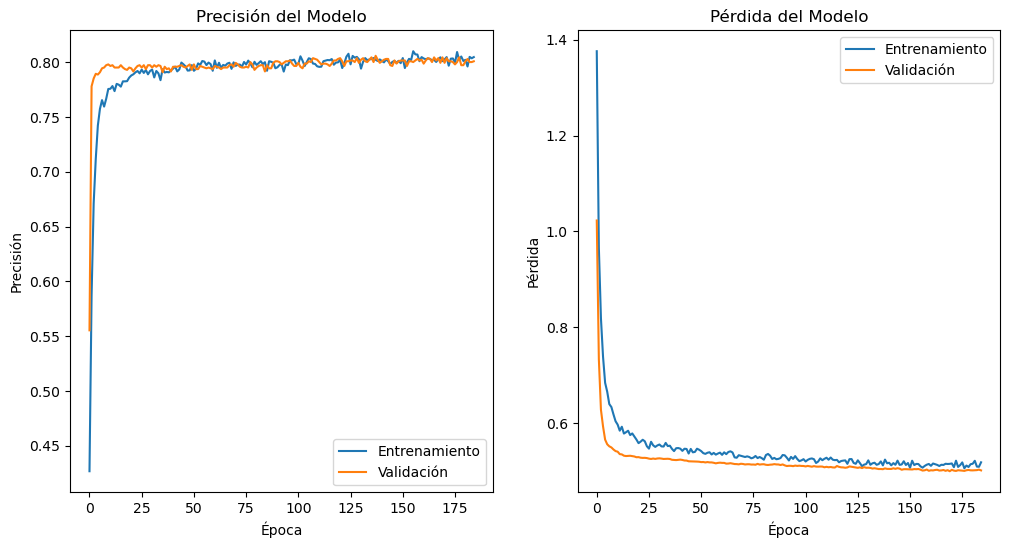

In [206]:
plt.figure(figsize=(12, 6))

# Plot Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del Modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

# Plot Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

In [210]:
best_model = load_model('./checkpoints/checkpoint')

In [211]:
resultados = best_model.evaluate(X_test, y_test)

44/44 [==============================] - 0s 2ms/step - loss: 0.4991 - accuracy: 0.8044


### Prediccion de los datos de prueba

In [212]:
X_prueba = pd.read_csv('test.csv')
X_prueba

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7905,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,7906,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,7907,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,7908,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,7909,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13171,2870,Placebo,12279,F,N,N,N,N,1.3,302.0,3.43,75.0,1345.0,145.00,44.0,181.0,10.6,3.0
5267,13172,1770,Placebo,24803,F,N,N,N,N,0.5,219.0,4.09,121.0,663.0,79.05,94.0,311.0,9.7,3.0
5268,13173,3707,D-penicillamine,16990,F,N,Y,N,N,0.8,315.0,4.09,13.0,1637.0,170.50,70.0,426.0,10.9,3.0
5269,13174,1216,Placebo,11773,F,N,N,N,N,0.7,329.0,3.80,52.0,678.0,57.00,126.0,306.0,10.2,1.0


In [214]:
id_ = X_prueba['id']
X_prueba = X_prueba.drop('id', axis =1)

In [215]:
 # Transformar variables
X_prueba = transformers_.transform(X_prueba)

In [217]:
# escalar y codificar
# Codificar variable categoricas
categorical_X = X_prueba.select_dtypes(exclude='number')

encoded_data_X = encoder.fit_transform(categorical_X)
columns_names_X = encoder.get_feature_names_out(categorical_X.columns)

# Transformar a df para concadenar a numericas
categorical_df_X = pd.DataFrame(encoded_data_X, columns=columns_names_X)
categorical_df_X.reset_index(drop=True, inplace=True)


# normaalizar variables numericas
numerical_X = X_prueba.select_dtypes(include='number')
columns_names_nx = numerical_X.columns

numerical_scaled_X = scaler.fit_transform(numerical_X)
# Transformar a df para concadenar con categoricas
numerical_df_X = pd.DataFrame(numerical_scaled_X, columns=columns_names_nx)

# Concadenamos a nuevo df
X_original_prueba = pd.concat([numerical_df_X, categorical_df_X], axis = 1)
X_original_prueba

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug_Placebo,Sex_M,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Edema_S,Edema_Y
0,0.798906,0.531493,0.548898,0.802130,0.526119,0.563208,0.690757,0.617593,0.429352,0.734531,0.533102,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.510517,0.282228,0.524165,0.848367,0.843284,0.636867,0.622180,0.617593,0.621233,0.329341,0.379368,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.002103,0.186385,0.674940,0.194980,0.373134,0.493991,0.541666,0.344679,0.472231,0.301397,0.869938,1.000000,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.481489,0.572748,0.319848,0.587029,0.705224,0.465961,0.335660,0.551006,0.239510,0.415170,0.533102,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.331090,0.645916,0.590251,0.561563,0.376866,0.687168,0.586317,0.549469,0.551134,0.317365,0.317735,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,0.595078,0.140720,0.570754,0.600263,0.548507,0.591804,0.640718,0.601358,0.134156,0.237525,0.533102,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5267,0.363694,0.798079,0.245778,0.441087,0.794776,0.687168,0.409579,0.388727,0.445665,0.497006,0.284614,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5268,0.771140,0.387991,0.424264,0.618151,0.794776,0.239503,0.690905,0.657897,0.331565,0.726547,0.595664,0.666667,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5269,0.247160,0.114161,0.377594,0.635960,0.686567,0.518555,0.418301,0.273509,0.551134,0.487026,0.435419,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [218]:
prueba_prediction = best_model.predict(X_original_prueba)
prueba_prediction

165/165 [==============================] - 0s 2ms/step


array([[0.63558614, 0.02675152, 0.3376624 ],
       [0.85714453, 0.05501156, 0.08784393],
       [0.04442025, 0.01662005, 0.9389596 ],
       ...,
       [0.8381913 , 0.0293327 , 0.13247609],
       [0.9458395 , 0.02307931, 0.03108117],
       [0.5303938 , 0.00811372, 0.46149254]], dtype=float32)

In [219]:
# Guardar en listas cada etiqueta con la probabilidad
Status_C = []
Status_CL = []
Status_D = []
for i in range(len(prueba_prediction)):
    Status_C.append(prueba_prediction[i, 0])
    Status_CL.append(prueba_prediction[i, 1])
    Status_D.append(prueba_prediction[i, 2])

In [220]:
# Creamos la submission
submission_test = {'id': id_, 'Status_C':Status_C, 'Status_CL':Status_CL,'Status_D':Status_D}

In [221]:
data = pd.DataFrame(submission_test)
data

,id,Status_C,Status_CL,Status_D
0,7905,0.635586,0.026752,0.337662
1,7906,0.857145,0.055012,0.087844
2,7907,0.044420,0.016620,0.938960
3,7908,0.914185,0.009322,0.076493
4,7909,0.553105,0.014216,0.432679
...,...,...,...,...
5266,13171,0.743154,0.089144,0.167702
5267,13172,0.934456,0.006123,0.059421
5268,13173,0.838191,0.029333,0.132476
5269,13174,0.945840,0.023079,0.031081


In [222]:
#Guardamos
data.to_csv('prediction_V1.csv', index=False)